In [23]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino

# Lecture 10

### Neural Network with :

Fashion MNIST


In [24]:
# Lets import some libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
%matplotlib inline


In [25]:
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random 

CMAP = plt.cm.bwr_r
# plt.rcParams.update(params)
# plt.set_cmap(CMAP)

plt.style.use('bmh')
    
EPOCHS = 100 # number of epochs
BATCH_SIZE = 32 # batch size
ALPHA = 0.001 # learning rate

ES_PATIENCE = 10 # if performance does not improve stop 
LR_PATIENCE = 5 # if performance is not improving reduce alpha
LR_FACTOR = 0.1 # rate of reduction of alpha

In [56]:
# Function to plot history

def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2, figsize = (15, 6))
    
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.4, edgecolor = 'b')
    
    ax = axes[0]
    
    hist_df.plot(y = [hist_df.columns[0], hist_df.columns[2]], ax = ax, colormap=CMAP)
    
    lossmin = hist_df[hist_df.columns[0]].min()
    
    testmin = hist_df[hist_df.columns[2]].min()
    
    fmtStr = "Min {}: \n Testing : {:7.4f}\n Testing  : {:7.4f}"
    
    txtstr = fmtStr.format(hist_df.columns[0], lossmin, testmin) # test to plot
    
    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    ax.set_xlabel("Epochs")
    
    ax.set_ylabel(hist_df.columns[0].capitalize())
    
    ax = axes[1]
    
    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap = CMAP)
    
    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    
    testmin = hist_df[hist_df.columns[3]].max()
    
    fmtStr = "Max {}: \n Training : {:7.4f}\n Testing  : {:7.4f}"
    txtstr = fmtStr.format(hist_df.columns[1], accmin, testmin) # text to plot
    
    ax.text(0.4, 0.5, txtstr, transform = ax.transAxes, fontsize = 14, verticalalignment='top', bbox=props)
    
    ax.set_label("Epochs")
    
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    plt.tight_layout()
        

## Read Fashion DataSet

In [26]:
train_df = pd.read_csv('fashion-mnist_train.csv' , header=0)
test_df = pd.read_csv('fashion-mnist_test.csv', header=0)

In [27]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [28]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [29]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


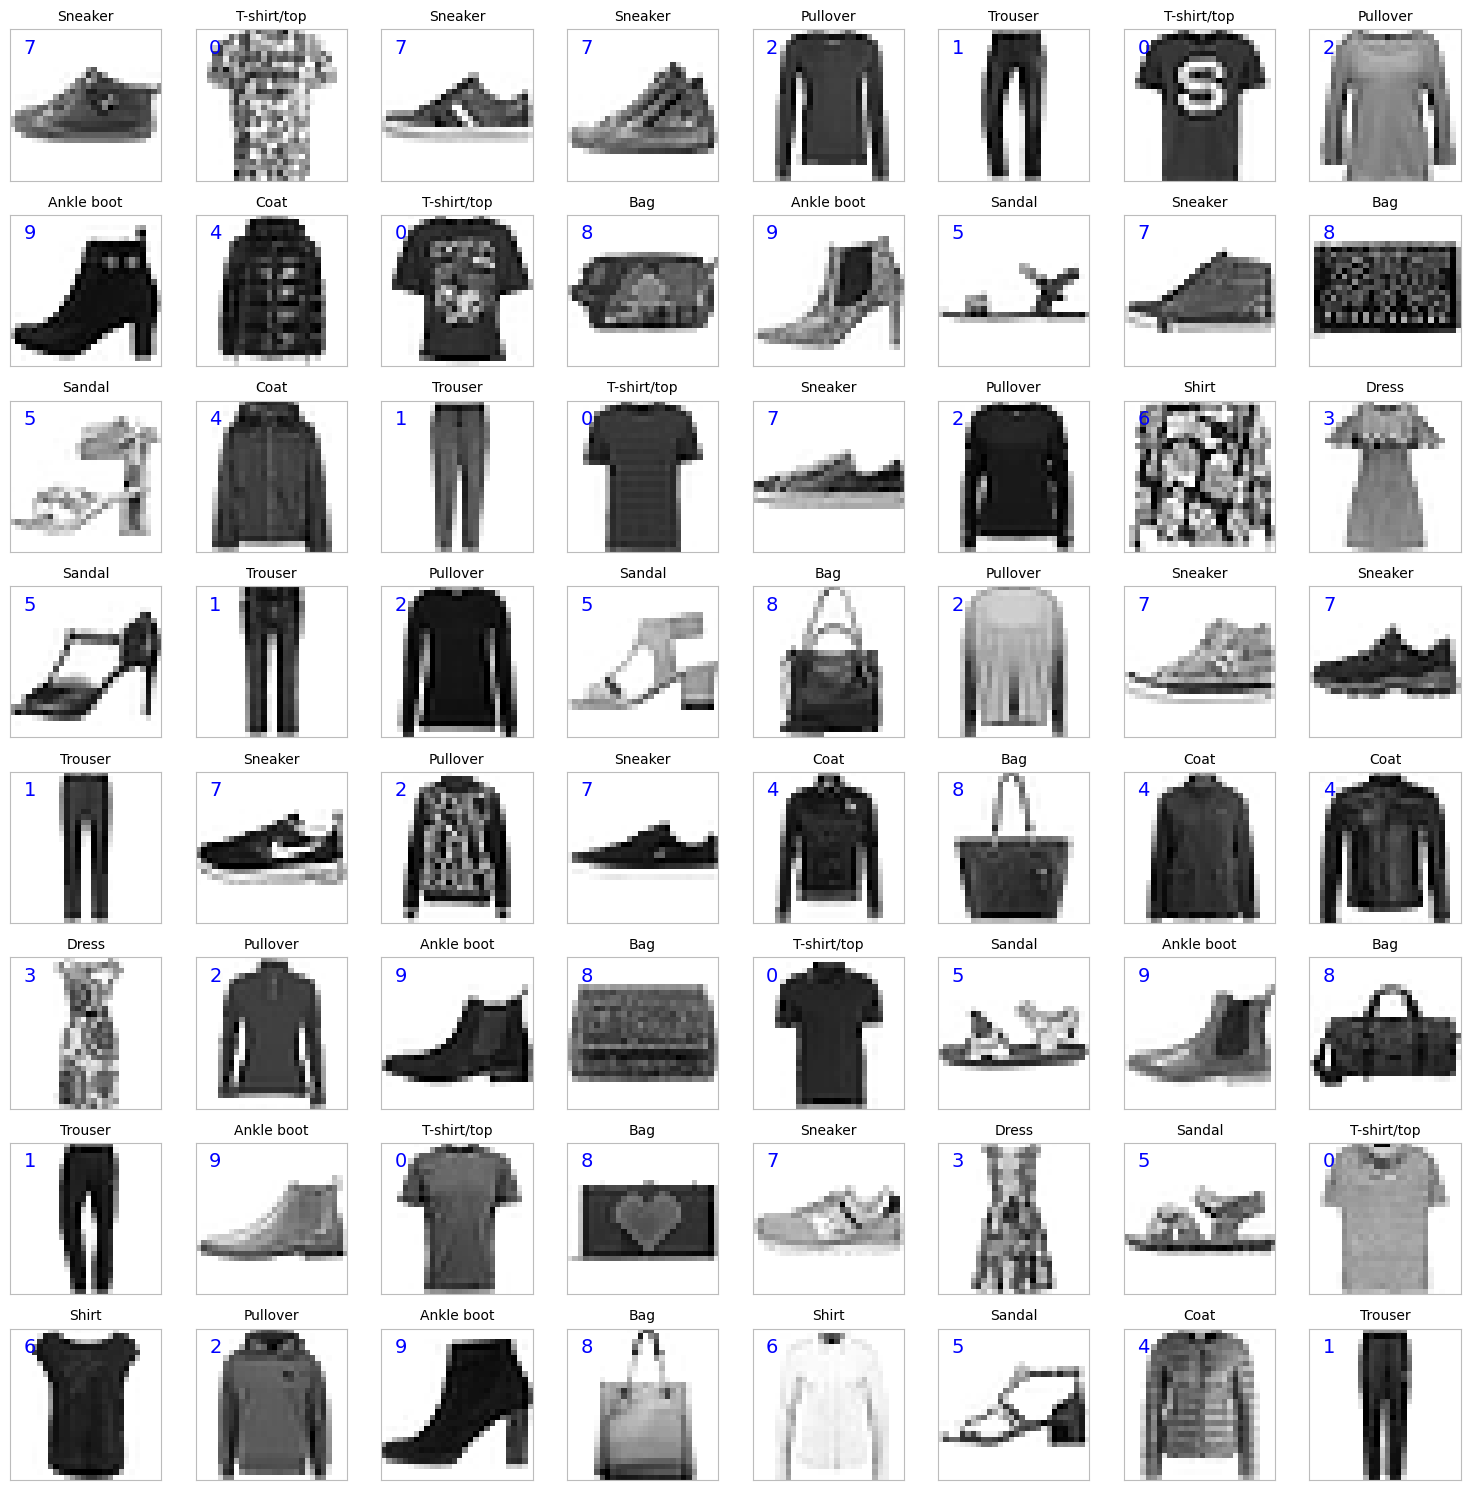

In [30]:
# Sample data plot

plot_df = train_df.sample(n = 64) # Take 100 sample from the training set

fig = plt.figure(figsize=(15, 15))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(8, 8, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=14)   # add number (class) of the image
    
    ax.set_title(class_names[row.iloc[0]], fontsize=10)   # add name of the image

plt.tight_layout() 
plt.show()

In [31]:
X_train = train_df.drop('label', axis=1).to_numpy()
y_train = train_df['label'].to_numpy()

X_test = test_df.drop('label', axis=1).to_numpy()
y_test = test_df['label'].to_numpy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [32]:
X_train.max()

255

In [33]:
X_train = X_train / 255.0

X_test = X_test / 255.0

# Prepare Model
Build `tf.keras.Sequential` model model by taking `tf.keras.layers.Dense`

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(784//4, activation = 'relu'),
    tf.keras.layers.Dense(784//16, activation = 'relu'),
    tf.keras.layers.Dense(10) # Ten classes
])
#model.output_shape

In [36]:
X_train[:1].shape

(1, 784)

In [39]:
X_train[:1]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [40]:
X_train[:1].shape

(1, 784)

In [41]:
predictions = model(X_train[:1])
predictions.numpy()

array([[ 0.25963432, -1.0925084 , -1.1589109 , -0.6334599 ,  0.45263982,
        -0.8693105 , -0.66531783,  0.4328639 ,  0.5109892 ,  0.39803243]],
      dtype=float32)

In [42]:
predictions = model(X_train[:1])
predictions.numpy().sum()

-2.3653479

In [43]:
tf.nn.softmax(predictions).numpy().sum()

0.99999994

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (1, 196)                  153860    
                                                                 
 dense_4 (Dense)             (1, 49)                   9653      
                                                                 
 dense_5 (Dense)             (1, 10)                   500       
                                                                 
Total params: 164013 (640.68 KB)
Trainable params: 164013 (640.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
import sys
sys.float_info.max, sys.float_info.min

(1.7976931348623157e+308, 2.2250738585072014e-308)

In [47]:
np.log(sys.float_info.max)

709.782712893384

In [48]:
np.exp(709)

8.218407461554972e+307

In [49]:
np.exp(710)

/tmp/ipykernel_1023097/574927170.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(710)


inf

In [50]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [51]:
y_test.shape

(10000,)

In [52]:
# print(y_test)

In [53]:
y_train[:1]

array([2])

In [54]:
loss_fn(y_train[:1], predictions).numpy()

3.4289436

## Compile the model:
- Loss Function
- Optimizer
- list metrices to monitor

## Fit the model
- Training features
- Training target
- validations
- batch size
- epochs

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
              loss=loss_fn,
              metrics=['accuracy'])


history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose='auto',
    validation_data=[X_test, y_test])

Epoch 1/100
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4940 - accuracy: 0.8253 - val_loss: 0.4022 - val_accuracy: 0.8505
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3689 - accuracy: 0.8664 - val_loss: 0.3595 - val_accuracy: 0.8707
Epoch 3/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3343 - accuracy: 0.8767 - val_loss: 0.3457 - val_accuracy: 0.8717
Epoch 4/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3088 - accuracy: 0.8874 - val_loss: 0.3354 - val_accuracy: 0.8800
Epoch 5/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2932 - accuracy: 0.8913 - val_loss: 0.3405 - val_accuracy: 0.8748
Epoch 6/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2768 - accuracy: 0.8972 - val_loss: 0.3146 - val_accuracy: 0.8856
Epoch 7/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2634 - accuracy: 0.9025 - val_loss: 0.3361 - v

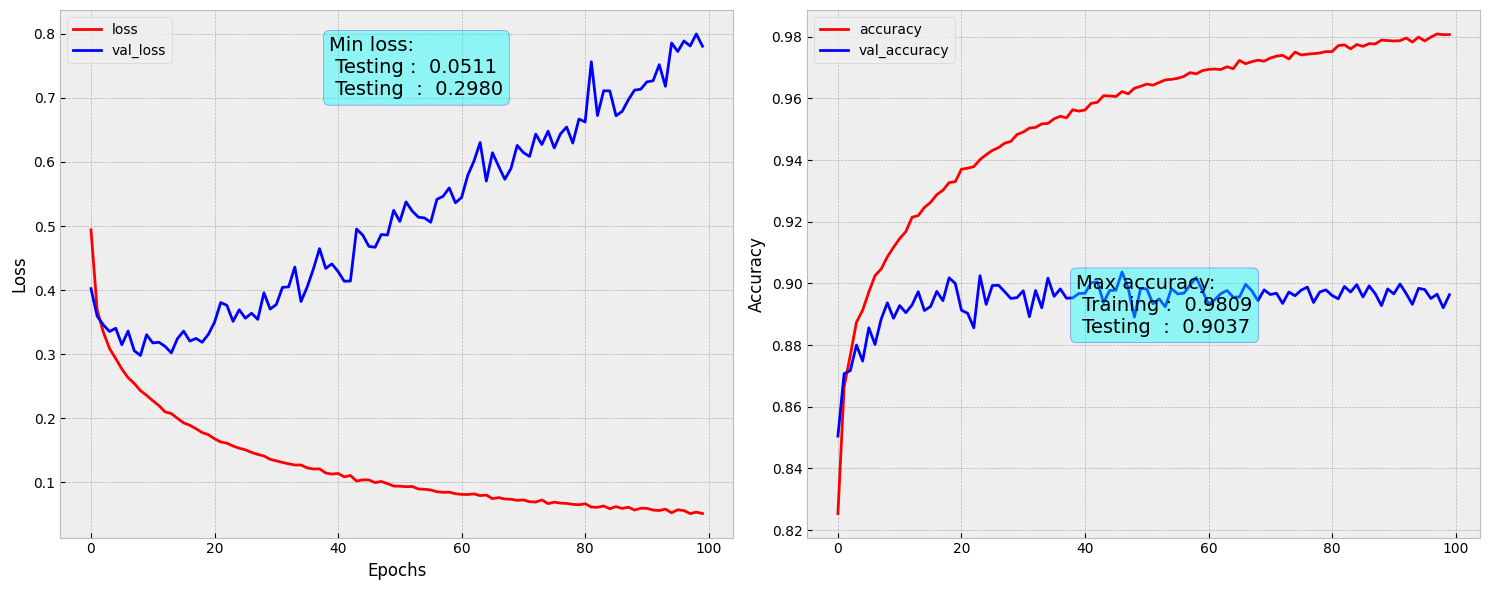

In [57]:
hist_df = pd.DataFrame(history.history)
fn_plot_hist(hist_df)

In [59]:
y_pred = model.predict(X_train)
y_pred = y_pred.argmax(axis=1)
print('Accuraccy score on Train Data :', accuracy_score(y_train, y_pred))

1875/1875 [==============================] - 5s 3ms/step
Accuraccy score on Train Data : 0.9837


In [60]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6000
           1       1.00      1.00      1.00      6000
           2       0.97      0.97      0.97      6000
           3       0.98      0.99      0.99      6000
           4       0.97      0.96      0.96      6000
           5       1.00      1.00      1.00      6000
           6       0.97      0.95      0.96      6000
           7       0.98      1.00      0.99      6000
           8       1.00      1.00      1.00      6000
           9       1.00      0.98      0.99      6000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



In [61]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print('Accuraccy score on Train Data :', accuracy_score(y_test, y_pred))

313/313 [==============================] - 1s 2ms/step
Accuraccy score on Train Data : 0.8963


In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.84      0.81      0.82      1000
           3       0.89      0.92      0.91      1000
           4       0.83      0.85      0.84      1000
           5       0.99      0.94      0.96      1000
           6       0.76      0.70      0.73      1000
           7       0.91      0.98      0.94      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [63]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[863,   2,  25,  22,   4,   1,  76,   0,   7,   0],
       [  1, 983,   0,  14,   0,   0,   2,   0,   0,   0],
       [ 22,   0, 811,  13,  83,   0,  70,   0,   1,   0],
       [ 19,   7,   6, 922,  31,   0,  13,   0,   2,   0],
       [  4,   0,  61,  29, 848,   0,  56,   0,   2,   0],
       [  0,   0,   1,   0,   0, 937,   1,  38,   3,  20],
       [153,   0,  59,  30,  54,   0, 697,   0,   7,   0],
       [  0,   0,   0,   0,   0,   6,   0, 976,   0,  18],
       [  4,   0,   5,   2,   3,   0,   4,   1, 981,   0],
       [  0,   0,   0,   1,   0,   1,   0,  52,   1, 945]])

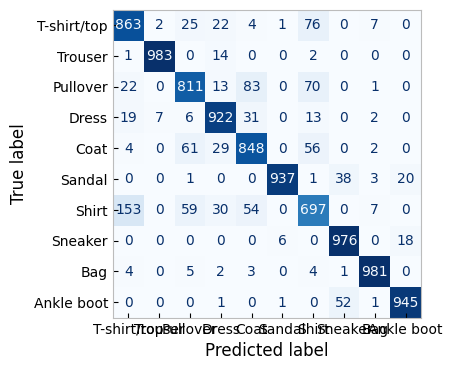

In [66]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar = False)

plt.grid(False)
plt.show()

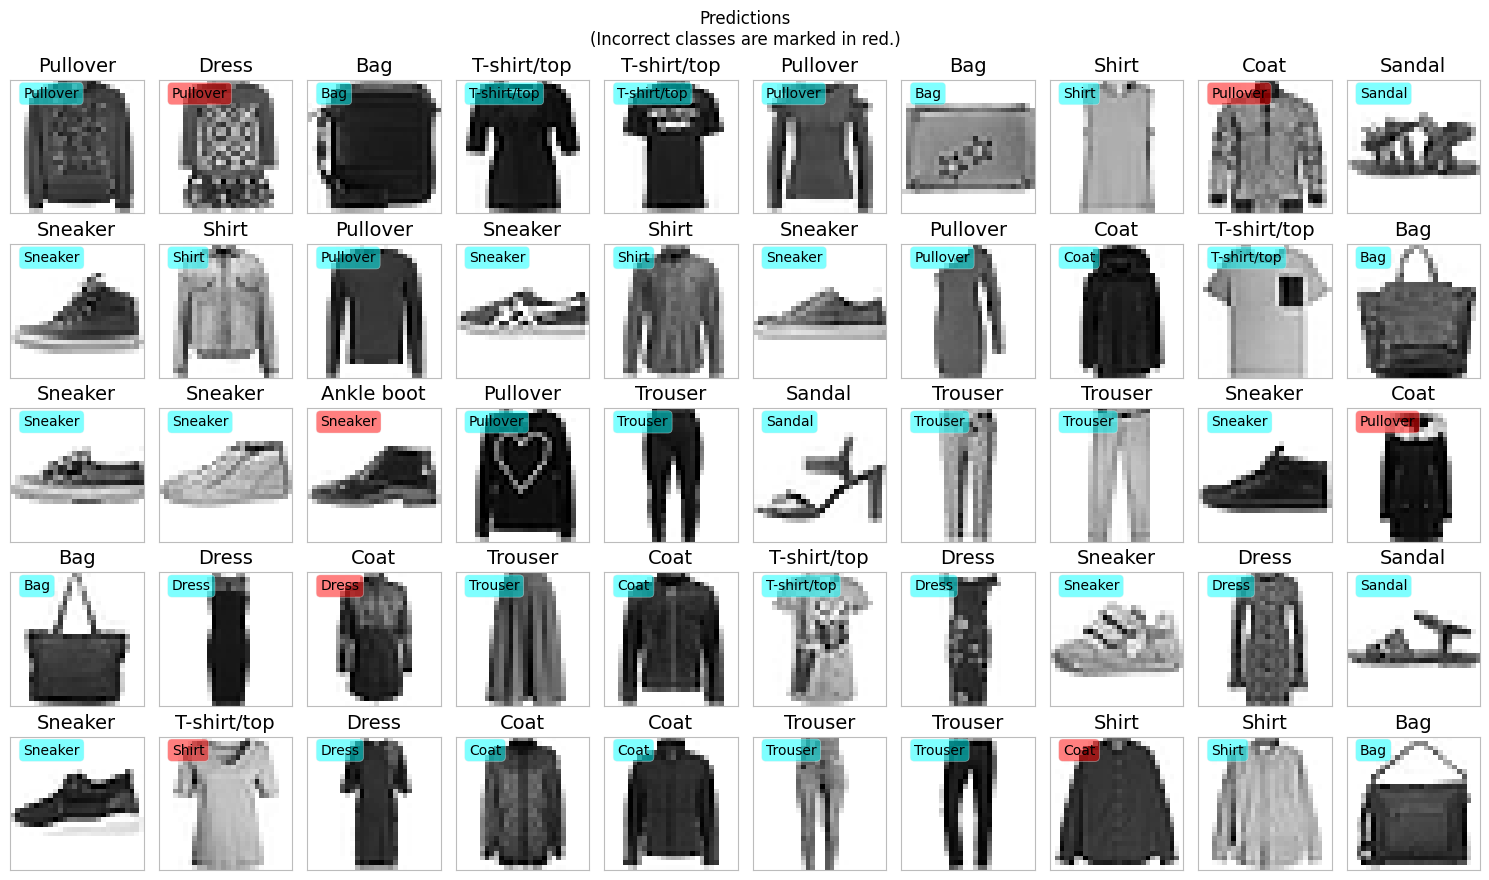

In [67]:
# Results data plot

test_df['y_pred'] = y_pred

plot_df = test_df.sample(n = 50) # Take 50 sample from the training set

fig = plt.figure(figsize=(15, 9))  # figure size in inches

i = 0

fntsize = 14

for _, row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    if row.iloc[0]!= row.iloc[-1]:
        color = 'red'
    else:
        color = 'cyan'

    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    ax = fig.add_subplot(5, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.set_title(class_names[row.iloc[0]], fontsize=fntsize)   # add number (class) of the image
    
    ax.text(0.1, 0.95, class_names[row.iloc[-1]], transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)   # add number (class) of the image
    
fig.suptitle('Predictions\n(Incorrect classes are marked in red.)')
plt.tight_layout()
plt.show()